In [3]:
# Load all parameters as tracked by dvc
import yaml

with open("params.yaml", 'r') as fd:
    PARAMS = yaml.safe_load(fd)

DATASET = PARAMS['dataset']

In [2]:
FOLD = 0
DATASET = 'dynamic'

In [4]:
import tensorflow as tf
tf.config.optimizer.set_jit(PARAMS['training']['jit_compile'])
# Important for SUMO-* servers
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        gpu = gpus[PARAMS['gpu_num']]
        tf.config.experimental.set_visible_devices(gpu, 'GPU')
        tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

import tensorflow_probability as tfp
tfd = tfp.distributions

print(tf.__version__)

import numpy as np

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2 Physical GPUs, 1 Logical GPU
2.6.0


In [5]:
data_val = tf.data.experimental.load(f'artifacts/{DATASET}/val_dataset_{FOLD}')
data_train = tf.data.experimental.load(f'artifacts/{DATASET}/train_dataset_orig_{FOLD}')

n_pos = np.array(list(data_train.filter(lambda x, y: (y == 1)).map(lambda p, q: q))).shape[0]
n_neg = data_train.cardinality() - n_pos

beta = (n_pos/n_neg).numpy()
beta

0.1310546875

In [6]:
from model import make_model

n_features = None
for X, y in data_train.as_numpy_iterator():
    n_features = X.shape[-1]

model = make_model(n_features, **PARAMS['training']['model'])
model.load_weights(f'artifacts/{DATASET}/saved_model_{FOLD}/model')

In [7]:
import pickle
with open(f'artifacts/{DATASET}/train_history_{FOLD}.pkl', 'rb') as f:
    history = pickle.load(f)

In [9]:
history.keys()

dict_keys(['loss', 'dense_5_loss', 'mean_prediction_binary_crossentropy', 'mean_prediction_accuracy', 'mean_prediction_auc_roc', 'mean_prediction_auc_pr', 'val_loss', 'val_dense_5_loss', 'val_mean_prediction_binary_crossentropy', 'val_mean_prediction_accuracy', 'val_mean_prediction_auc_roc', 'val_mean_prediction_auc_pr'])

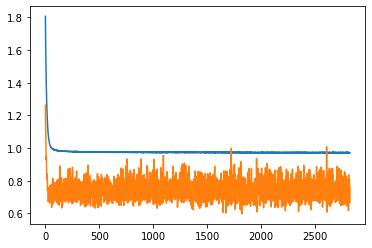

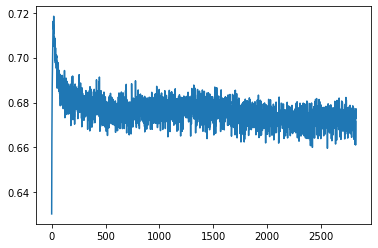

In [12]:
from matplotlib import pyplot as plt

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.figure()
plt.plot(history['val_mean_prediction_auc_roc'])

In [8]:
np.argmax(history['val_loss'])

0

In [9]:
len(history['val_loss'])

2826

In [10]:
from tqdm.notebook import tqdm
preds = []
for x, y in data_val.batch(data_val.cardinality()):
    print(y)
    for i in tqdm(range(300)):
        p_s = model(x, training=True)['outp_pos']
        
        p = p_s/(p_s + ((1-p_s)/beta))
        preds.append(p)
        #preds.append(cclf.predict_proba(x)[:,1])

tf.Tensor([0 0 0 ... 0 0 0], shape=(27364,), dtype=int64)


  0%|          | 0/300 [00:00<?, ?it/s]

In [11]:
import numpy as np
import pickle
import json
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score, classification_report, brier_score_loss

mean_predictions = np.array(preds).squeeze().mean(axis=0)
metrics = {
    'aucroc': roc_auc_score(y, mean_predictions),
    'aucpr': average_precision_score(y, mean_predictions),
    'brierscore': brier_score_loss(y, mean_predictions),
}

with open(f'artifacts/{DATASET}/evaluation/{FOLD}.pkl', 'wb') as f:
    pickle.dump(metrics, f)

print(metrics)

{'aucroc': 0.6984010015417903, 'aucpr': 0.23635110730358855, 'brierscore': 0.10649336492715936}


In [12]:
#preds = [tf.nn.softmax(p[:,:2])[:,1] for p in preds]
#preds = preds[0][:,None]

In [13]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [14]:
np.array(preds).squeeze().T.shape

(27364, 300)

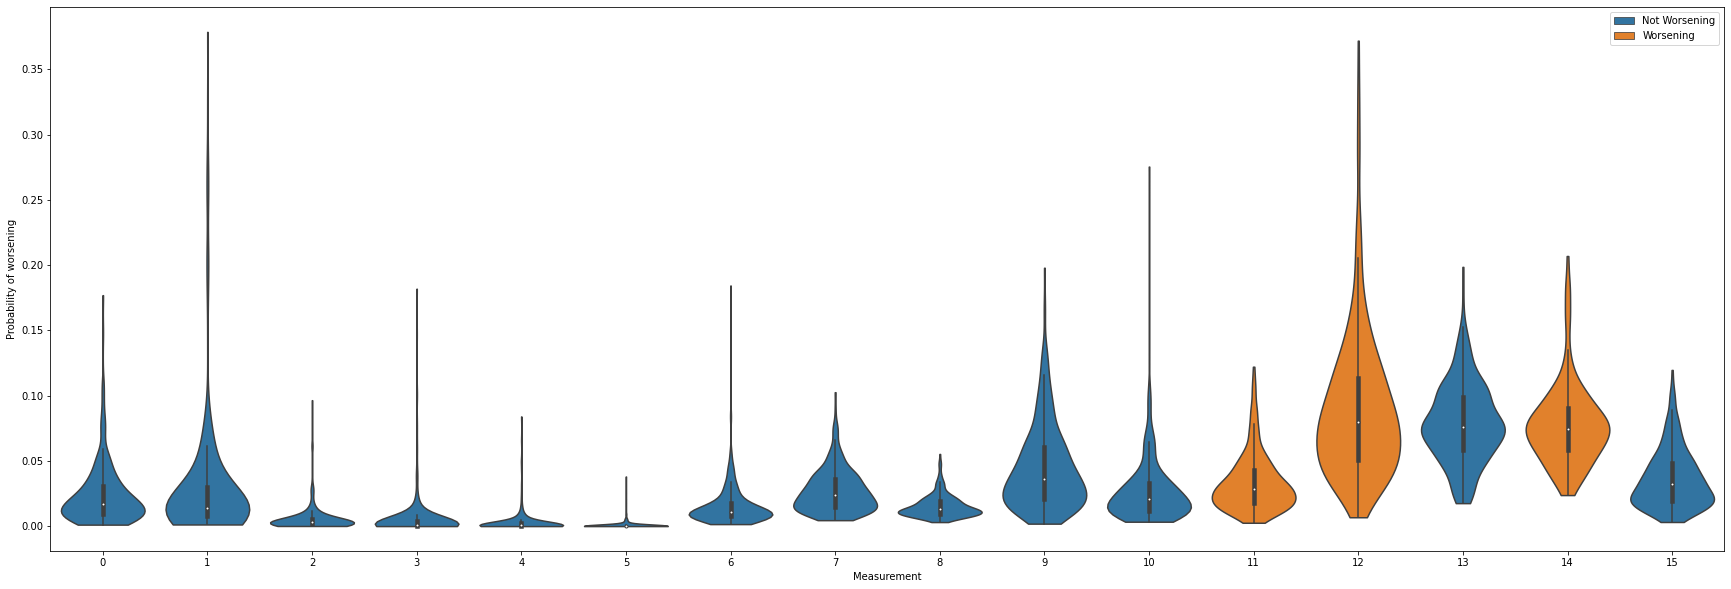

In [40]:
plt.figure(figsize=(30,10 ))

offset = 1600
n = 16

ax = sns.violinplot(
    x=np.arange(n*300)//300,
    y=np.array(preds).squeeze().T[offset:offset+n].reshape(-1),
    hue=y[offset:offset+n].numpy()[np.arange(n*300)//300],
    dodge=False,
    cut=0,
)
plt.ylabel("Probability of worsening")
plt.xlabel("Measurement")
ax.legend(handles=ax.legend_.legendHandles, labels=['Not Worsening', 'Worsening'])
#plt.legend([0,1], ['Not Worsening', 'Worsening'])

# Calculate epistemic uncertainty over variance

In [14]:
from sklearn.calibration import calibration_curve

In [15]:
from sklearn.metrics import auc, brier_score_loss, f1_score, precision_recall_curve, roc_curve
def calc_calibration_curve(y_true, y_pred, window_size, z):
    y_stack = np.stack([y_true, y_pred], axis = -1)[np.argsort(y_pred)]
    y_stack_extended = np.concatenate([np.array([y_stack[0]] * (window_size - 1)), 
                                       y_stack, 
                                       np.array([y_stack[-1]] * (window_size - 1))], axis = 0)

    prob_true = np.convolve(y_stack_extended[:, 0], np.ones(window_size), 'valid') / window_size
    prob_pred = np.convolve(y_stack_extended[:, 1], np.ones(window_size), 'valid') / window_size

    def wilson_score_interval(p_hat, window_size, z):

        def _wilson_score_interval(p_hat_):
            if not z > 0 or window_size == 0:
                return 0.5, 0.0, 1.0

            first_term = (p_hat_ + z**2 / (2 * window_size)) / (1 + z**2 / window_size)
            second_term = z / (1 + z**2 / window_size) * ((p_hat_ * (1 - p_hat_) / window_size) / window_size + z**2 / 
                                                          (4 * window_size**2))**0.5

            lower_bound = first_term - second_term
            upper_bound = first_term + second_term

            return lower_bound, upper_bound

        return np.apply_along_axis(_wilson_score_interval, 0, p_hat).T

    confidence_bounds = wilson_score_interval(prob_true, window_size, z)
    brier_score = brier_score_loss(y_true, y_pred)
    # r_squared = 1 - np.sum((prob_pred - prob_true)**2) / np.sum((prob_pred - np.mean(prob_pred))**2)

    return prob_true, prob_pred, confidence_bounds, brier_score # r_squared

In [16]:
np.array(preds).mean(axis=0).shape

(28546, 1)

0.09999467533491473


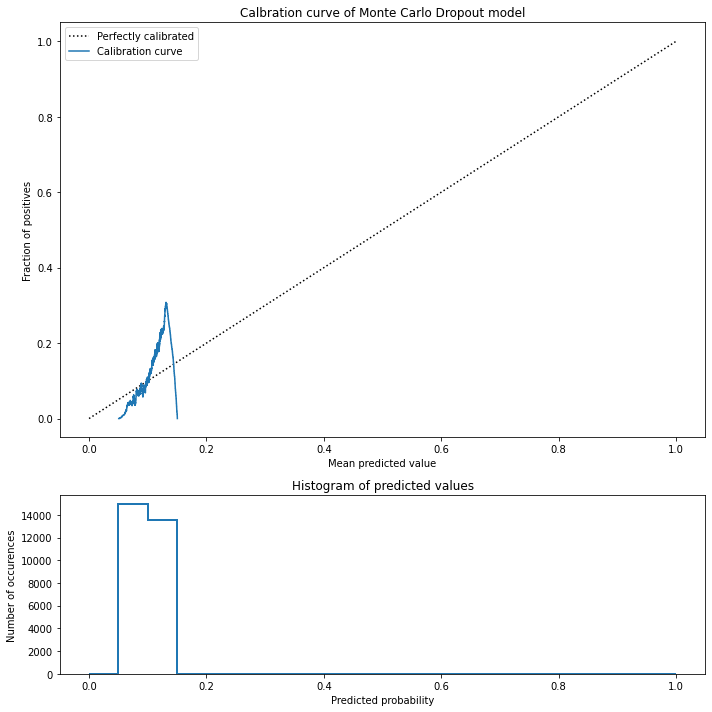

In [17]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

#fraction_of_positives, mean_predicted_value = calibration_curve(y, np.array(preds).mean(axis=0).squeeze(), n_bins=100)
fraction_of_positives, mean_predicted_value, confidence_bounds, brier_score = calc_calibration_curve(y, np.array(preds).mean(axis=0).squeeze(), 1000, 1.96)
print(brier_score)

ax1.plot(mean_predicted_value, fraction_of_positives, "-", label="Calibration curve")
ax1.set_xlabel("Mean predicted value")
ax1.set_ylabel("Fraction of positives")
ax1.set_title("Calbration curve of Monte Carlo Dropout model")
ax2.hist(np.array(preds).mean(axis=0).squeeze(), range=(0, 1), bins=20, histtype="step", lw=2)
ax2.set_title("Histogram of predicted values")
ax2.set_xlabel("Predicted probability")
ax2.set_ylabel("Number of occurences")
ax1.legend()
plt.tight_layout()